In [30]:
#11/5~
#完成。号機管理表OCR開始版。

In [44]:
#必要なモジュールの読み取り。
import cv2
import numpy as np
from pathlib import Path
from google.cloud import vision
import os
import sys
import pandas as pd
import re
import glob
from natsort import natsorted
import io
import json
import traceback

import math
import matplotlib
import matplotlib.pyplot as plt
import copy

from PIL import Image, ImageDraw, ImageFilter
import easyocr
import torch

import datetime

In [45]:
#ここで、環境変数”GOOGLE_APPLICATION_CREDENTIALS”にパスを通しています。
#絶対パスだと認証が通らなかったけど、相対パスだと認証が通りました。
#GoogleAPIの認証に必要です。
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/all/Downloads/acceleration-307107-af3f79bfeb64.json'
client = vision.ImageAnnotatorClient()

In [77]:
### 対象の表部分のみを抽出する関数
def TableDivide(img_path):
    #号機管理表を上下に分けるコード。
    
    img = cv2.imread(img_path,0) #号機管理表を読み込む。
    
    ksize=3 
    img_mask = cv2.medianBlur(img,ksize) #各ピクセルに対し、そこを中心に3*3のマスで輝度の平均を取る。
    
    #ピクセルの周りの白が２ピクセル以下であれば黒に、３以上であれば白に二値化される。黒のゴマ塩ノイズを消去するための処理
    
    #cv2.thresholdの第一引数は大値の二値化につかい、第二引数は、二値化した画像を出力する。
    ret, img_thresh = cv2.threshold(img_mask,60,255,cv2.THRESH_BINARY) 
    black_hist = []
    y_pixel = len(img_thresh) #順にy,xのピクセル数 
    x_pixel = len(img_thresh[0])
    
    for line in range(y_pixel):
        black_hist.append(np.sum(img_thresh[line])/255) #y軸の値に対し、横(x=const上)に白のピクセル数を取った合計※白=255,黒=0です
    
    breaks = []
    for i in reversed(range(1,y_pixel)):
        if (black_hist[i] == x_pixel) and (black_hist[i-1] != x_pixel): #yの値が大きい順から、y=Yで白一色だが、y=Y-1で白一色でないようなYを表のブレークとして格納
            if i > 20:
                if black_hist[i-20] == x_pixel:
                    continue
            breaks.append(i)
    breaks.sort()        
    
    #これ以後は、表の形によって変わる。
    #y座標のうち、全て白色のピクセルで構成されているものが、breaksに格納されている。
    if len(breaks)>=2:
        table=img[(breaks[-2]+2):]
        cv2.imwrite('type_name.png', table)

    else:
        table=img
        cv2.imwrite('type_name.png', table)

        
    
        
    return "type_name.png" #cv2の行列形式で、切り取った表をreturn

In [78]:
### 表の枠線認識に使用する諸々関数

def imgReduction1(Path):
    #画像内の文字を消して、罫線だけにする関数part1
#     img_path = "/Users/all/Downloads/test_accord/ACCORD 4D-2007_7 (1).png"

    # easyocrの設定
    reader = easyocr.Reader(['ja','en'], gpu = False)
    
    print("reader完了")

    # テキストの検出
    results = reader.readtext(Path)

    # 検出したデータの配列を扱いやすいようにdict型に変換
    detects = []
    
    for result in results:
        detect = {
            "position" : (
                (int(result[0][0][0])+3, int(result[0][0][1])+5),
                (int(result[0][1][0])-3, int(result[0][1][1])+5),
                (int(result[0][2][0])-3, int(result[0][2][1])-5),
                (int(result[0][3][0])+3, int(result[0][3][1])-5)
            ),
            "text"     : result[1],
            "confident": result[2]
        }
        if (int(result[0][3][1])-5) - (int(result[0][1][1])+5) < 30:
            detects.append(detect)
#             print(detect)
    
    # オリジナルの画像
    img_original = Image.open(Path)
    img_original = img_original.convert('RGBA')
    # オリジナルの画像にぼかしを入れたもの
    img_white = Image.new("L", img_original.size, 255)
    # マスクで使用する画像
    img_mask = Image.new("L", img_original.size, 0)

    draw = draw = ImageDraw.Draw(img_mask)

    for d in detects:
        draw.polygon(d["position"], fill=255)

    img_mask_blur = img_mask.filter(ImageFilter.GaussianBlur(5))


    img_original.paste(img_white, (0, 0), img_mask)
    img_original.save("test_easyocr.png")
    
    return "test_easyocr.png"


def imgReduction2(Path):
    #画像内の文字を消して、罫線だけにする関数part2
    img = cv2.imread(Path)
    blurred_img = cv2.GaussianBlur(img,(9,1),25) #横にブラー
    ret, hlines = cv2.threshold(blurred_img,25,255,cv2.THRESH_BINARY) 
    blurred_img = cv2.GaussianBlur(img,(1,9),25) #縦にブラー
    ret, vlines = cv2.threshold(blurred_img,25,255,cv2.THRESH_BINARY) 
    
    wimg = (hlines/2 + vlines/2)  #二つの画像を足し合わせる
    ret, lines = cv2.threshold(wimg,128,255,cv2.THRESH_BINARY) #値が127以下のもの(二枚の画像の少なくとも一つで黒であるピクセル)を0にする
    cv2.imwrite("tmp.png", lines)
    return "tmp.png"


def read_lines(input_FN, height, threshold_param):
    #画像から直線を取得する。
    #
    #詳細###
    #openCVを使って、入力画像に次の処理を行う。
    # 1. [画像処理] 画像の読み取り
    # 2. [画像処理] カラーデータをグレーデータに変換
    # 3. [画像処理] 直線検出の準備として、白黒を反転させる。
    # 4. [画像処理] 直線検出(ハフ変換による直線検出)
    # 5. [数値処理] 同直線の統合: 始点終点が、他の線と近ければ、統一する。
 
    #height = parameter["height"]
 
    #読み取り
    img = cv2.imread(input_FN)
 
    #グレーに変換
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
    #白黒反転
    gray_2 = cv2.bitwise_not(gray)
     
    #直線検出
    bare_lines = cv2.HoughLinesP(gray_2, rho=1, theta=np.pi/180, threshold=threshold_param, minLineLength=80, maxLineGap=5)
    #直線群のデータ構造: [[x1, y1, x2, y2], [x1, y1, x2, y2], [x1, y1, x2, y2], ...]
    #各直線が配列内に順番に並んでいて、それぞれの中では始点終点の座標が格納されている。    
    #同直線の統合
    line_p_size = 10
    threshold_size = 10
    ori_lines_bare = integrate_lines(bare_lines, threshold_size)
    
    ori_lines = []
    for line in ori_lines_bare:
        line_cont = line[0]
        ori_lines.append([line_cont[0], line_cont[1], line_cont[2], line_cont[3]])
 
    return ori_lines
 
def integrate_lines(bare_lines, threshold_size):
    #同一の直線と思われる直線を統合する。
 
    #詳細###
    #入力された直線群の中から、直線を一個ずつ選び、他の直線と比較
    #始点終点が他と近くなければ、新規直線としてint_linesに格納していく。
    #最終的には、int_lines内に格納された直線同士は、始点終点が互いに異なる。
 
    ori_lines = []
     
    for bare_lines_cont in bare_lines:
        for int_lines_cont in ori_lines:
            #2直線の始点と終点の差分d1, d2を算出して、それが共に指定距離よりも近くにあるかどうかで、同じ直線かどうかを判断する。
            d1 = math.sqrt((int_lines_cont[0][0] - bare_lines_cont[0][0])**2 + (int_lines_cont[0][1] - bare_lines_cont[0][1])**2)
            d2 = math.sqrt((int_lines_cont[0][2] - bare_lines_cont[0][2])**2 + (int_lines_cont[0][3] - bare_lines_cont[0][3])**2)
            if d1 < threshold_size and d2 < threshold_size:
                #同じ直線だと判断した場合
                break
        else:
            #同じ直線がまだint_linesの中にない場合には、新規直線として追加する。
            ori_lines.append(bare_lines_cont)
 
    return ori_lines
 
def para(int_lines):
    #全ての直線をx,y軸に平行にする。
 
    #詳細###
    # 0. 直線群に対して1つずつ処理を行う。
    # 1. 縦線か横線かを判断
    # 2. 縦線ならxを、横線ならyを始点終点で一致させる。
    # 3. 斜め線の場合には警告
    # 4. 返り値は座標軸平行に整えられた直線(の始点終点座標)群
 
    para_lines = [] #座標軸に対して平行に整えられた直線が格納される。
 
    for line_cont in int_lines:
        x1, y1, x2, y2 = line_cont
        #縦か横かの判断を行い、座標を整える。
        dx = abs(x1-x2)
        dy = abs(y1-y2)
        if dx < dy: #縦線
            x_out_1 = (x1+x2)/2
            x_out_2 = x_out_1
            y_out_1 = y1
            y_out_2 = y2
        else: #横線
            x_out_1 = x1
            x_out_2 = x2
            y_out_1 = (y1+y2)/2
            y_out_2 = y_out_1
        #斜めの線の時には警告する。
        if abs(dx-dy)/((dx+dy)/2) < 0.5:
            print("There is a diagonal line!!!")
        para_lines.append([x_out_1, y_out_1, x_out_2, y_out_2])
 
    return para_lines
 
def fusion(para_lines, size):
    #各直線が、他の直線と重なっているかを確認し、
    #重なっていれば、融合する。
 
    #size = (height + width)/2
 
    fuse_lines = [] #結合された直線が格納される。
    fused_list = []
 
    for line_n in range(len(para_lines)):
        if line_n in fused_list:
            continue
        new_line = copy.copy(para_lines[line_n])
        for line_n_n in range(len(para_lines)):
            if line_n != line_n_n:
                new_line, fusion_switch = fusion_lines(new_line, para_lines[line_n_n], size)
                if fusion_switch == 1: #2直線が結合された場合
                    fused_list.append(line_n_n)
        fuse_lines.append(new_line)
 
    return fuse_lines
 
def fusion_lines(lineA, lineB, size):
    #2つの直線の方向を確認し、違う方向ならlineAを返し、
    #同じ方向なら、lineAとlineBが重なっているかを確認し、
    #重なっていればlineAを返し、重なっていれば2直線を融合してつなぎ合わせる。
    #直線の返り値と共に、結合したかどうかを0/1で返す。
 
    #2つの線が同じ方向かの確認
    #方向が違えば、lineAを返して終了
    if lineA[0] == lineA[2]:
        A_angle = "x"
    else:
        A_angle = "y"
 
    if lineB[0] == lineB[2]:
        B_angle = "x"
    else:
        B_angle = "y"
 
    if A_angle != B_angle:
        return lineA, 0
 
    #方向が同じ場合に、直線が重なっているかを確認
    if A_angle == "x":
        distance = abs(lineA[0] - lineB[0])
        pA = [min(lineA[1], lineA[3]), max(lineA[1], lineA[3])]
        pB = [min(lineB[1], lineB[3]), max(lineB[1], lineB[3])]
    else:
        distance = abs(lineA[1] - lineB[1])
        pA = [min(lineA[0], lineA[2]), max(lineA[0], lineA[2])]
        pB = [min(lineB[0], lineB[2]), max(lineB[0], lineB[2])]
 
    if distance > size/100: #もしも2つの線が十分に離れていれば、lineAを返して終了
        return lineA, 0
 
    if pA[0] > pB[1] or pB[0] > pA[1]: #重なっていなければ、lineAを返して終了
        return lineA, 0
 
    #ここまで処理が回った=2つの直線は重なっているため、
    #直線の方向(x軸に平行か、y軸に平行か)に応じて、融合する。
    #融合時には、2直線を足し合わせたようにする。
    if A_angle == "x":
        x = (lineA[0] + lineA[2] + lineB[0] + lineB[2])/4
        y1 = min(lineA[1], lineA[3], lineB[1], lineB[3])
        y2 = max(lineA[1], lineA[3], lineB[1], lineB[3])
        new_line = [x, y1, x, y2]
    else:
        y = (lineA[1] + lineA[3] + lineB[1] + lineB[3])/4
        x1 = min(lineA[0], lineA[2], lineB[0], lineB[2])
        x2 = max(lineA[0], lineA[2], lineB[0], lineB[2])
        new_line = [x1, y, x2, y]
 
    return new_line, 1
 
def coordinate(fuse_lines, merge_r):
    #各直線の始点終点座標を、近い点で揃える。
    #そろえる範囲をcoor_dで指定する。
    in_lines = copy.deepcopy(fuse_lines)
 
    for i, line in enumerate(in_lines):
        for k in [0,2]: #x軸方向 in_lines[i][k]の全てを回す。
            for j, line_cont in enumerate(in_lines):
                for g in [0,2]:
                    if i==j and k==g: continue
                    if abs(line[k] - line_cont[g]) < merge_r:
                        in_lines[j][g] = line[k]
        for k in [1,3]: #y軸方向 in_lines[i][k]の全てを回す。
            for j, line_cont in enumerate(in_lines):
                for g in [1,3]:
                    if i==j and k==g: continue
                    if abs(line[k] - line_cont[g]) < merge_r:
                        in_lines[j][g] = line[k]
 
    return in_lines

def plot_lines(lines, main_table_path):
    #入力された直線と元画像をグラフにplotする。
 
    fig = plt.figure()
    plt.xlim(0, 2000)
    plt.ylim(0, 2000)
    plt.xlabel("x [-]")
    plt.ylabel("y [-]")
    plt.title("Lines")
    plt.gca().invert_yaxis()
    
    main_table = plt.imread(main_table_path)
    plt.imshow(main_table)
 
    #取得した直線のplot
    for line_cont in lines:
        x = [line_cont[0], line_cont[2]] #[始点座標、終点座標]
        y = [line_cont[1], line_cont[3]] #[始点座標、終点座標]
        plt.plot(x, y, color="blue")
 
    #画像として保存する。
    FN = "/Users/all/Downloads/OCR結果11.5/table_detection/"+"table_detection_"+img_path.split("/")[-1]
    
    fig.savefig(FN)
 
    return 0

In [79]:
### 表の罫線認識のメイン関数

def digi_conv_main(main_table_path, threshold_param):
    # 直線認識と繋ぎ合わせや微調整により表を成形する関数

#     print("Diigtal conversion prosecc is working...")
    
    #文字を削除して表のみの状態にする。
    pre_input_FN = imgReduction2(main_table_path)
    input_FN = imgReduction2(pre_input_FN)
    
    #直線の始点終点を揃える範囲[pixel]
    merge_r = 10.0
     
    #画像のサイズを取得する。
    img = cv2.imread(input_FN, cv2.IMREAD_COLOR)
    height, width = img.shape[:2]   #入力画像の縦、横の大きさ
    size = (height + width)/2       #入力画像の大まかな大きさ。点の重なり判断の指標に使われる。
 
    #画像から直線を取得する。
    ori_lines = read_lines(input_FN, height, threshold_param)
 
    #取得した直線を全て、x軸に平行もしくはy軸に平行な直線に直す。
    para_lines = para(ori_lines)
 
    #重なっている線を結合する。
    fuse_lines = fusion(para_lines, size)
 
    #統合された線の両端を揃える。
    coor_lines = coordinate(fuse_lines, merge_r)
    #このcoor_linesの中身が整えられた最終的な直線群
    #直線群のデータ構造: [[x1, y1, x2, y2], [x1, y1, x2, y2], [x1, y1, x2, y2], ...]
    #各直線が配列内に順番に並んでいて、それぞれの中では始点終点の座標が格納されている。
 
    #読み取った線をplot

    plot_lines(coor_lines, main_table_path)
    
    return coor_lines, size

In [80]:
# # パラメータ選択型。結局全パラメータ合体型に変更した。param_fusion参照。
# def digi_conv_select(main_table_path):
#     coorlength_max = 0
#     coorlist_max = 0
#     for threshold_param in range(60,121,10):
#         coorlength = 0
#         coor_lines = digi_conv_main(main_table_path, threshold_param)
#         for coorline in coor_lines:
#             coorlength += (coorline[2] - coorline[0]) + (coorline[3] - coorline[1])  
#         if ((coorlength_max < coorlength) & (coorlist_max == len(coor_lines))) | coorlist_max < len(coor_lines):
#             coorlist_max = len(coor_lines)
#             coorlength_max = coorlength
#             coor_lines_max = coor_lines
#             print(threshold_param)
#             print(coorlist_max)
#             print(coorlength_max)
#     return coor_lines_max

In [81]:
def param_fusion(main_table_path):
    for threshold_param in range(60,121,10):
        if threshold_param == 60:
            coor_lines, size = digi_conv_main(main_table_path, threshold_param)
        else:
            coor_lines += digi_conv_main(main_table_path, threshold_param)[0]
    
    #同一直線統合
    coor_lines = np.array(coor_lines).reshape(-1,1,4).tolist()
    int_lines_bare = integrate_lines(coor_lines, 10)
    
    int_lines = []
    for line in int_lines_bare:
        line_cont = line[0]
        int_lines.append([line_cont[0], line_cont[1], line_cont[2], line_cont[3]])
    
    #重なっている線を結合する。
    fuse_lines = fusion(int_lines, size)
 
    #統合された線の両端を揃える。
    coor_lines_fusion = coordinate(fuse_lines, 10.0)
    
    plot_lines(coor_lines_fusion, main_table_path)

    return coor_lines_fusion

In [82]:
### 画像加工に使用する諸々関数

def vlines_x_list(coor_lines):
    # 縦線x座標の重複なし昇順リスト作成
    vlines_x_list = []
    for coorline in coor_lines:
        if (coorline[0] == coorline[2]) & (coorline[0] not in vlines_x_list):
            vlines_x_list.append(coorline[0])
    vlines_x_list = sorted(vlines_x_list)  

    return vlines_x_list


def hlines_y_list(coor_lines):
    # 横線のy座標の重複なし昇順リスト作成
    hlines_y_list = []
    for coorline in coor_lines:
        if (coorline[1] == coorline[3]) & (coorline[1] not in hlines_y_list):
            hlines_y_list.append(coorline[1])                    
    hlines_y_list = sorted(hlines_y_list)
    
    # もし「モデルコード」・「モデル」「コード」間の罫線が存在しなかった場合、これのy座標を架空の線としてリストに加える
    # 目的：「上から3番目の横線 = 列名とデータを区切る長い横線」であるという対応づけを成立させるため。
    for coorline in coor_lines:
        if (coorline[1] == coorline[3] == hlines_y_list[1]) & ((coorline[2]-coorline[0]) > 500):
            virtual_line_y = (hlines_y_list[0] + hlines_y_list[1])/2
            hlines_y_list.append(virtual_line_y)
            hlines_y_list = sorted(hlines_y_list)
            break
    
    return hlines_y_list

def cellbottomline_index_y_list(idx,coor_lines):
    # ある1列について、各セルのhlines_y_listにおけるindexとy座標を返す関数
    x_list = vlines_x_list(coor_lines)
    y_list = hlines_y_list(coor_lines)
    cellbottomline_idx_list = []
    cellbottomline_y_list = []
    partation = False
    
    for coorline in coor_lines:
        if (coorline[1] == coorline[3] > y_list[0]) & (coorline[0] < x_list[idx+1]) & (coorline[2] > x_list[idx]):
            cellbottomline_idx = y_list.index(coorline[1])
            cellbottomline_idx_list.append(cellbottomline_idx-2)
            cellbottomline_y_list.append(coorline[1])
            
            if coorline[1] == y_list[1]:
                partation = True
    cellbottomline_idx_list = sorted(cellbottomline_idx_list)
    cellbottomline_y_list = sorted(cellbottomline_y_list)

    return cellbottomline_idx_list, cellbottomline_y_list, partation

In [83]:
### 画像加工のメイン関数

def save_trimming_img(img_path, coor_lines):
    # 縦線で切り分けて列ごとに画像を保存
    x_list = vlines_x_list(coor_lines)
    img = Image.open(img_path)
    trimming_list = []
    
    for i,vline in enumerate(x_list[:-1]):
        boolean = False
        img_crop = img.crop((x_list[i],0,x_list[i+1],img.height))
        filename = 'trimming_img{0}.png'.format(i+1)
        img_crop.save(filename, quality=95)
        trimming_list.append(filename)
        
    return trimming_list

In [84]:
### 文字認識に使用する諸々関数

def detect_text(path):
    # 一列分OCR
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()
    data_list_text=[]

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.text_detection(
        image=image,
        image_context={"language_hints":["en","ja"]}
    )
    texts = response.full_text_annotation
    
    text_y_list=[]
    bounds = []
    for page in texts.pages:
        for block in page.blocks:
#             bounds = block.bounding_box
#             center_y = (bounds.vertices[0].y + bounds.vertices[2].y) / 2
#             block_text = []
            for paragraph in block.paragraphs:
#                 bounds = paragraph.bounding_box
#                 center_y = (bounds.vertices[0].y + bounds.vertices[2].y) / 2
#                 block_text = []
                for word in paragraph.words:
                    bounds = word.bounding_box
                    center_y = (bounds.vertices[0].y + bounds.vertices[2].y) / 2
                    block_text = []
                    for symbol in word.symbols:
                        block_text.append(symbol.text)
                        block_text = [''.join(block_text)]
                    text_y_list.append([block_text[0], center_y])
#             print("text_y_list in detect_text", text_y_list)
    return text_y_list
    
    
def make_single_column(idx, text_y_list, coor_lines):
    # 文字認識出力をデータフレームに変換
    y_list = hlines_y_list(coor_lines)
#     print("hlines_y_list:",y_list)
    
    cellbottomline_idx_list = cellbottomline_index_y_list(idx, coor_lines)[0]
    cellbottomline_y_list = cellbottomline_index_y_list(idx, coor_lines)[1]
    partation = cellbottomline_index_y_list(idx, coor_lines)[2]
    if partation == True:
        print("partation==True")
        cellbottomline_idx_list.pop(0)
        cellbottomline_y_list.pop(0)
        if text_y_list[0][1] < y_list[1]:
            text_y_list.pop(0)

    if len(text_y_list) != len(cellbottomline_idx_list):
#         print("text_y_list:", text_y_list)
#         print("cellbottomline_y_list:", cellbottomline_y_list)
#         print("長さ不一致")
#         write_list = ["\n長さ不一致\ntext_y_list:",text_y_list,"\ncellbottomline_list:",cellbottomline_list]
#         with open("/Users/all/Downloads/images_files/output.txt", mode="w") as f:
#             f.write("\n長さ不一致\ntext_y_list:")
#             f.write(str(text_y_list[0]))
#             f.write("\ncellbottomline_list:")
#             f.write(str(",".join(cellbottomline_list)))
        #####
        irregular_text_list = []
        for idx in range(len(cellbottomline_idx_list)):
            irregular_text = []
            irregular_y = []
            for text_y in text_y_list:
                if idx == 0:
                    if text_y[1] <= cellbottomline_y_list[idx]:
                        irregular_text.append(text_y[0])
                        irregular_y.append(text_y[1])
                else:
                    if cellbottomline_y_list[idx-1]<text_y[1]<=cellbottomline_y_list[idx]:
                        irregular_text.append(text_y[0])
                        irregular_y.append(text_y[1])
            for y in range(1,len(irregular_y)):
                if irregular_y[y] - irregular_y[y-1] > 100:
                    with open("/Users/all/Downloads/OCR結果11.5/error_message/output11.5.txt", mode="a") as f:
                        f.write("\n-------線読み取り失敗確定-------")
            irregular_text_list.append("".join(irregular_text))
        column_name = irregular_text_list[0]
        text_cell_list = []
        for i in range(1, len(cellbottomline_idx_list)):
            text_cell_list += [irregular_text_list[i]]*(cellbottomline_idx_list[i] - cellbottomline_idx_list[i-1])
#         print("cellbottomline_y_list:", cellbottomline_y_list)    
#         print("column_name:", column_name)
#         print("text_cell_list:", text_cell_list)
#         print("text_y_list:", text_y_list)

    else:
        column_name = text_y_list[0][0]
        text_cell_list = []
        for i in range(1, len(text_y_list)):
            text_cell_list += [text_y_list[i][0]]*(cellbottomline_idx_list[i] - cellbottomline_idx_list[i-1])
#         print("cellbottomline_y_list:", cellbottomline_y_list)    
#         print("column_name:", column_name)
#         print("text_cell_list:", text_cell_list)
#         print("text_y_list:", text_y_list)
        
    single_column = pd.DataFrame({column_name: pd.Series(text_cell_list)})
    return single_column

In [85]:
### 文字認識のメイン関数

def make_df_by_OCR(trimming_img_list, coor_lines):
    # 
    df_list = []
    for idx, trim in enumerate(trimming_img_list):
        text_y_list = detect_text(trim)
        df_column = make_single_column(idx, text_y_list, coor_lines)
        if df_column is None:
            continue
        else:
            df_list.append(df_column)
            
    for i,df in enumerate(df_list):
        if i == 0:
            df_part = df
        else:
            df_part = pd.concat([df_part,df], axis=1)
    return df_part

In [86]:
### 各処理をまとめたメイン関数。1車種分の取得情報のデータフレームを返す。

def main(img_path):
    
    main_table_path = TableDivide(img_path)
    
    coor_lines = param_fusion(main_table_path)
    
    plot_lines(coor_lines, main_table_path)
    
    trimming_img_list = save_trimming_img(main_table_path, coor_lines)  
    
    df_part = make_df_by_OCR(trimming_img_list, coor_lines)
    
    return df_part

In [87]:
natsorted(glob.glob("/Users/all/Downloads/eparts_images/image_necessary/*")).index( '/Users/all/Downloads/eparts_images/image_necessary/CIVIC 3D')

28

/Users/all/Downloads/eparts_images/image_necessary/CIVIC 3D/号機管理表/CIVIC 3D_号機管理表_2000_(3,EL,4AT)_6_.png
/Users/all/Downloads/eparts_images/image_necessary/CIVIC 3D/号機管理表/CIVIC 3D_号機管理表_2000_(3,RI,5MT)_2_.png
/Users/all/Downloads/eparts_images/image_necessary/CIVIC 3D/号機管理表/CIVIC 3D_号機管理表_2000_(3,RI,5MT)_3_.png


<ipython-input-78-94c2775c7983>:264: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


/Users/all/Downloads/eparts_images/image_necessary/CIVIC 3D/号機管理表/CIVIC 3D_号機管理表_2000_(3,RI,HMM)_7_.png
/Users/all/Downloads/eparts_images/image_necessary/CIVIC 3D/号機管理表/CIVIC 3D_号機管理表_2000_(3,SIR,4AT)_4_.png
/Users/all/Downloads/eparts_images/image_necessary/CIVIC 3D/号機管理表/CIVIC 3D_号機管理表_2000_(3,SIR,5MT)_5_.png
/Users/all/Downloads/eparts_images/image_necessary/CIVIC 3D/号機管理表/CIVIC 3D_号機管理表_2000_(3,VTI,5MT)_1_.png
/Users/all/Downloads/eparts_images/image_necessary/CIVIC 3D/号機管理表/CIVIC 3D_号機管理表_2003_(3,TYPE R,6MT)_1_.png
partation==True
partation==True
/Users/all/Downloads/eparts_images/image_necessary/CIVIC 3D/号機管理表/CIVIC 3D_号機管理表_2010_(3,2.0 TYPE-R    EURO,6MT)_1_.png
partation==True
partation==True


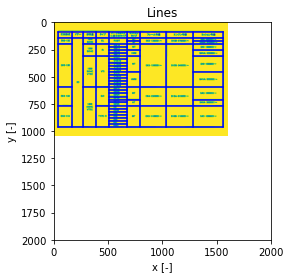

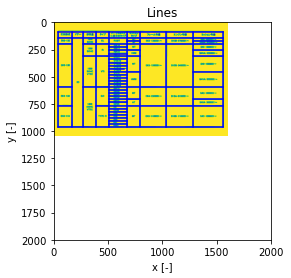

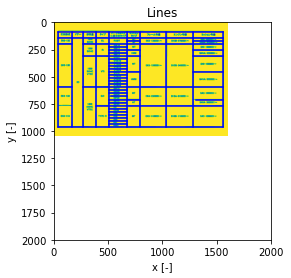

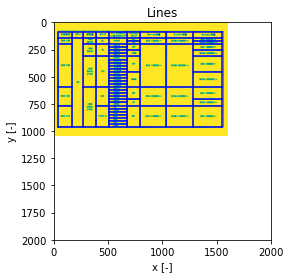

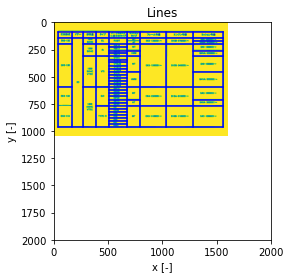

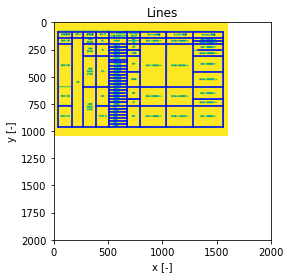

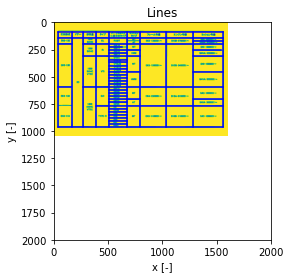

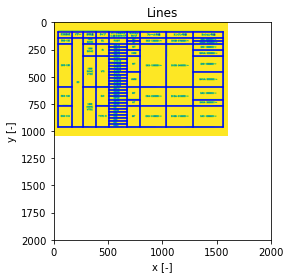

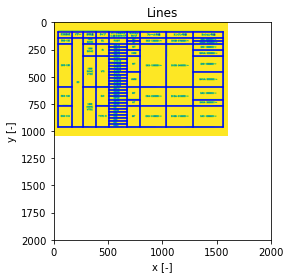

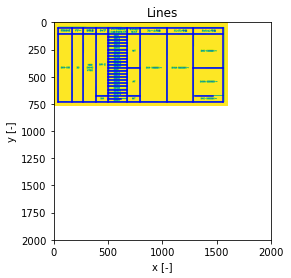

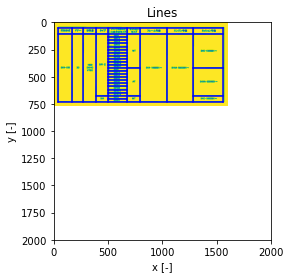

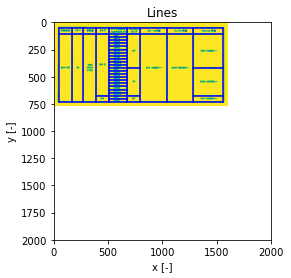

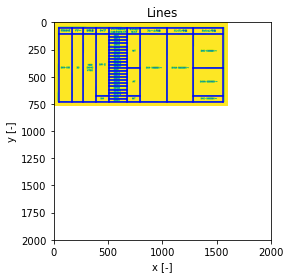

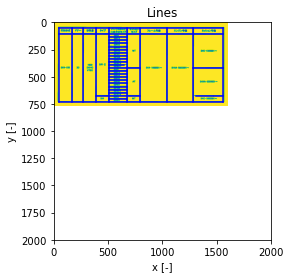

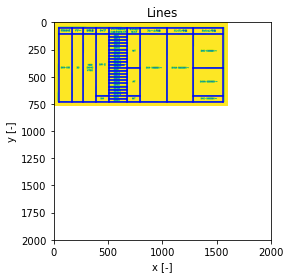

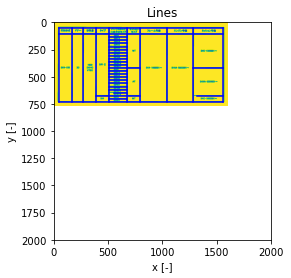

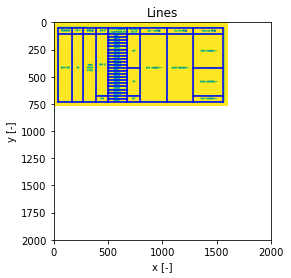

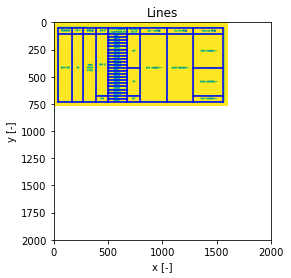

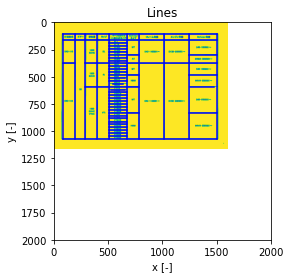

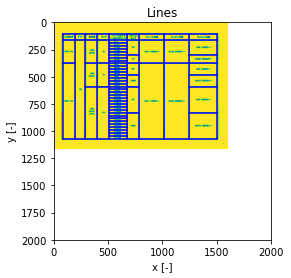

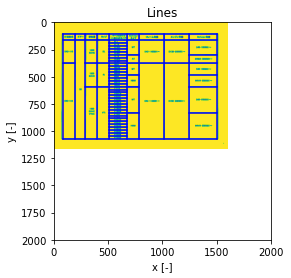

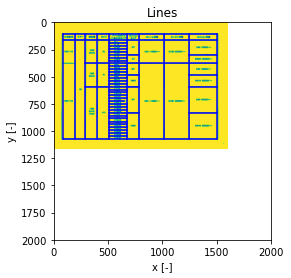

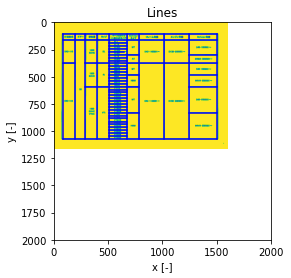

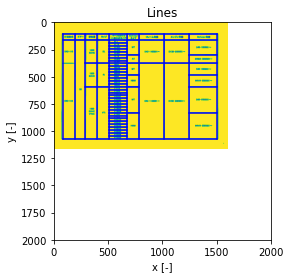

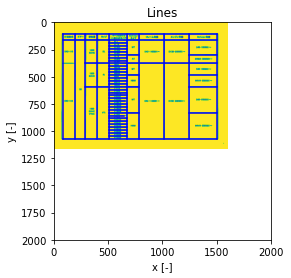

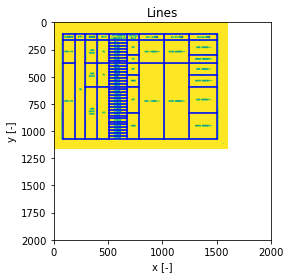

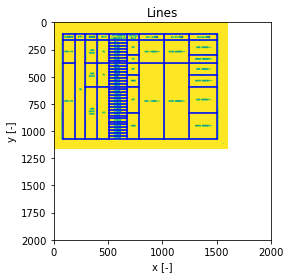

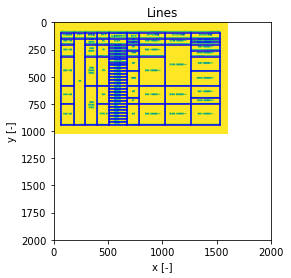

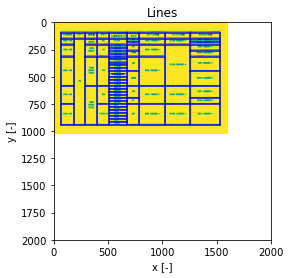

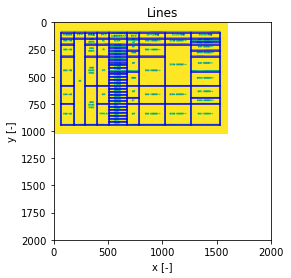

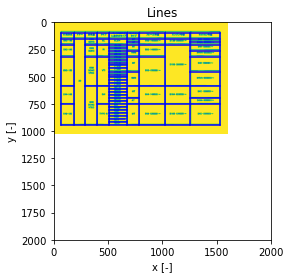

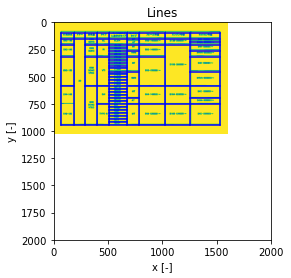

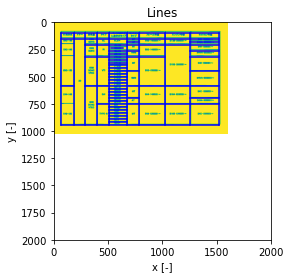

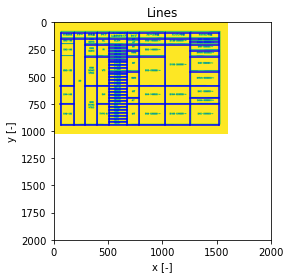

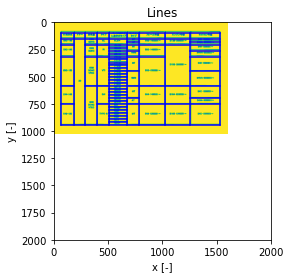

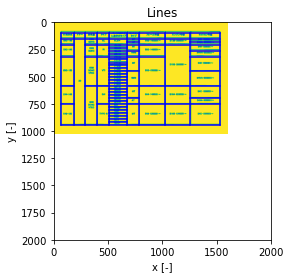

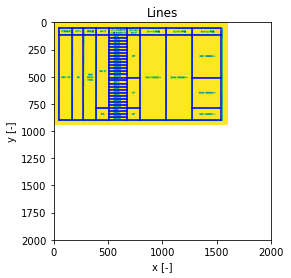

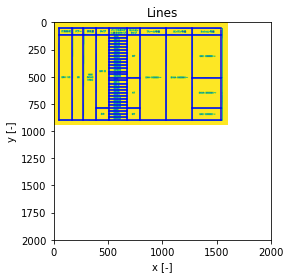

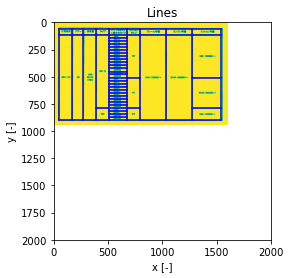

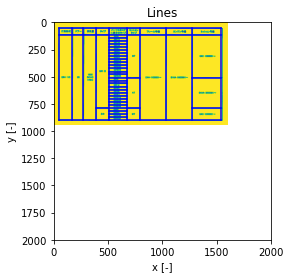

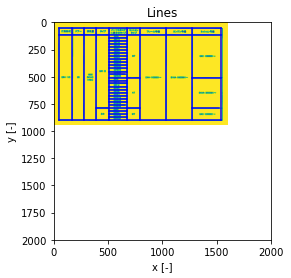

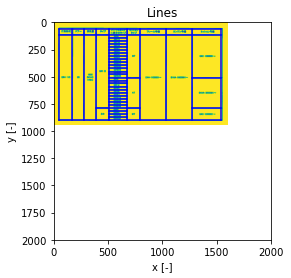

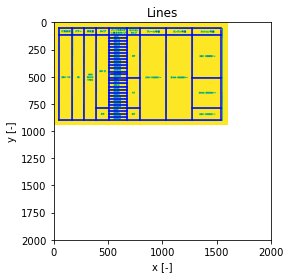

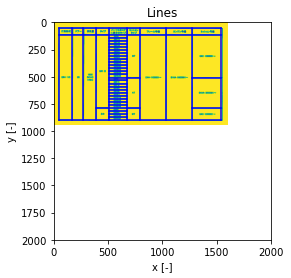

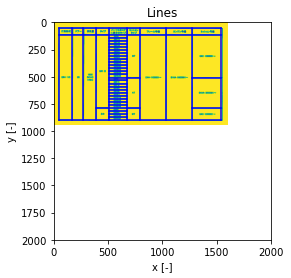

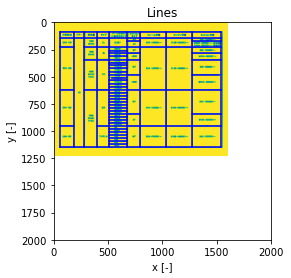

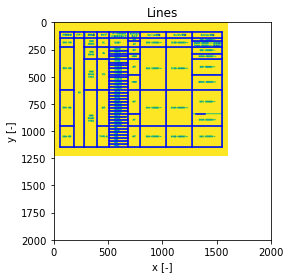

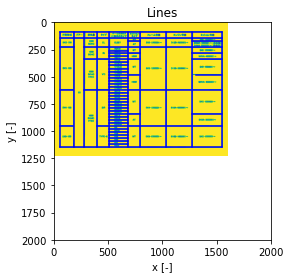

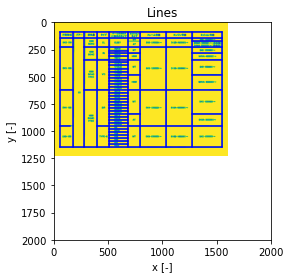

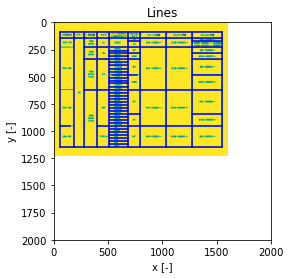

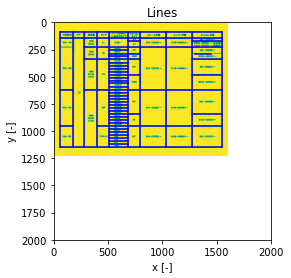

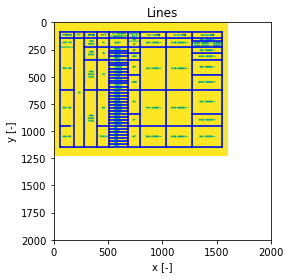

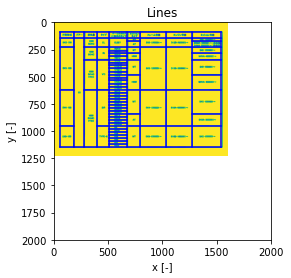

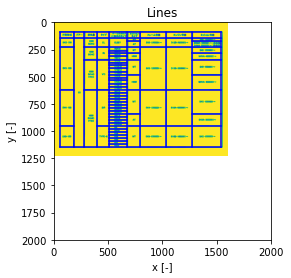

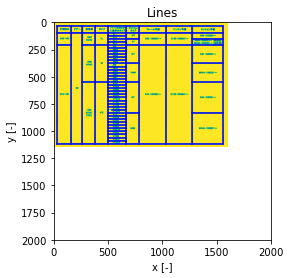

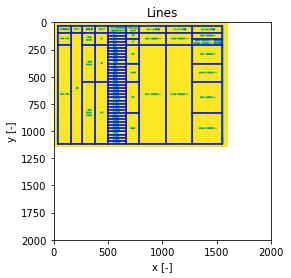

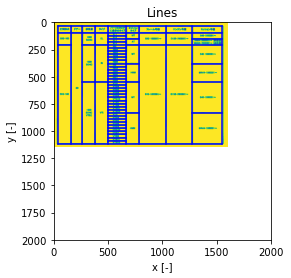

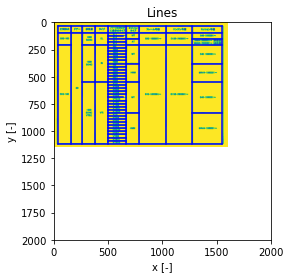

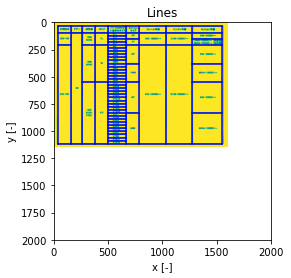

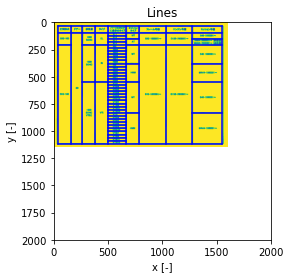

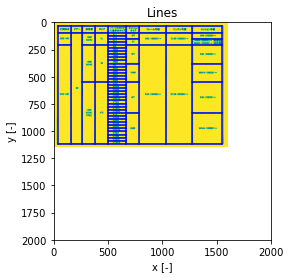

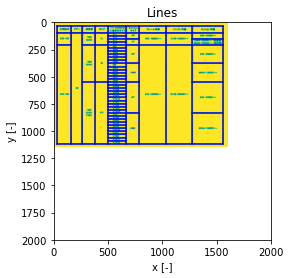

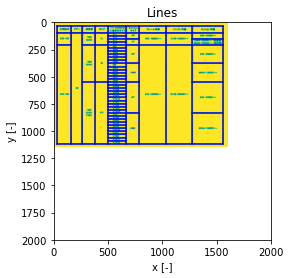

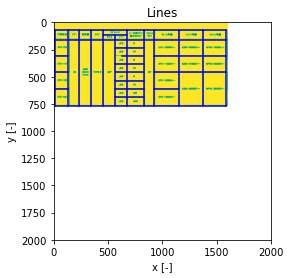

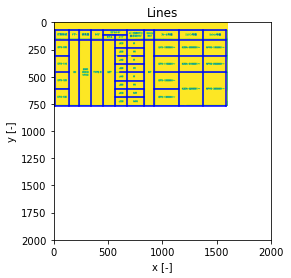

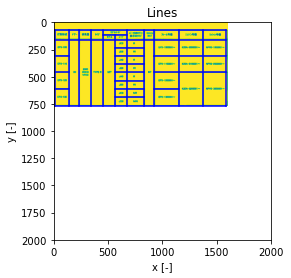

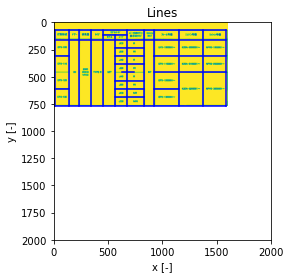

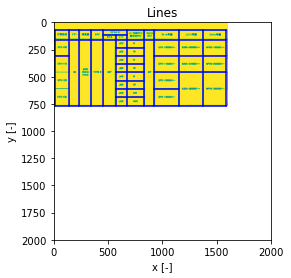

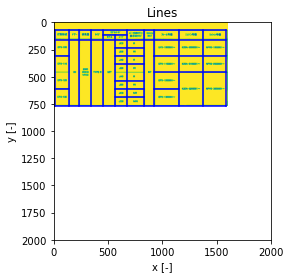

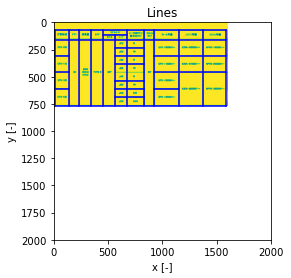

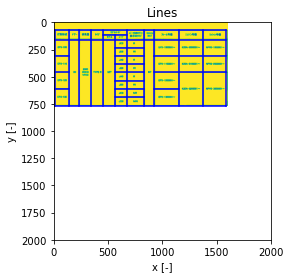

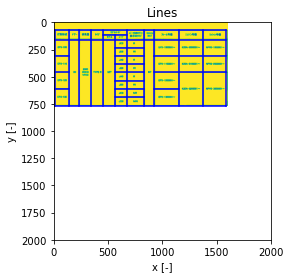

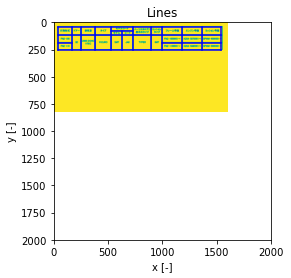

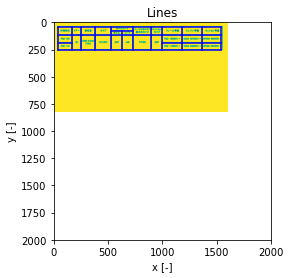

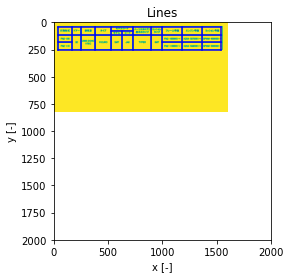

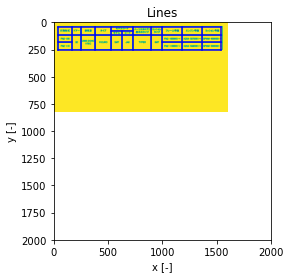

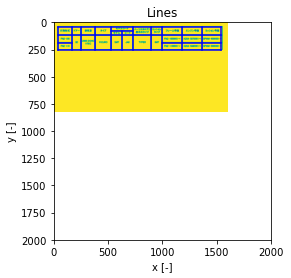

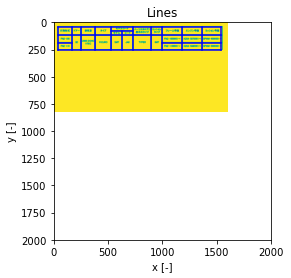

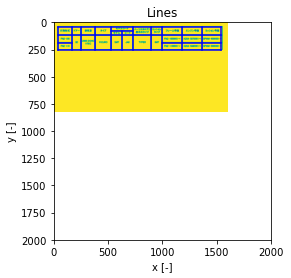

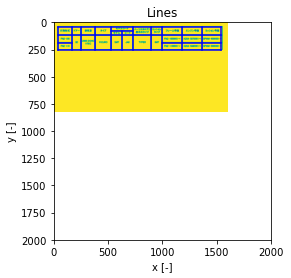

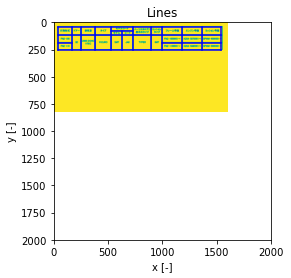

In [88]:
### 実行セル
for file_i, vehicle_type in enumerate(natsorted(glob.glob("/Users/all/Downloads/eparts_images/image_necessary/*"))):
    vehicle_type = vehicle_type.split("/")[6]
    with open("/Users/all/Downloads/OCR結果11.5/error_message/output11.5.txt", mode="a") as f:
        f.write("\n"+vehicle_type)
    if file_i < 29:
        continue
        
    path_name = "/Users/all/Downloads/eparts_images/image_necessary/"+vehicle_type+"/号機管理表/*" 
    for count, img_path in enumerate(natsorted(glob.glob(path_name))):
        
#         #特定のファイルで動かしたい場合
#         if count != 2:
#             continue
            
        print(img_path)
        with open("/Users/all/Downloads/OCR結果11.5/error_message/output11.5.txt", mode="a") as f:
            f.write("\n"+img_path)

        #メインプログラムの呼び出し
        df_partial = main(img_path)
        
        #データフレーム化、逐一csvファイルで保存
        
#         #特定のファイルで動かしたい場合
#         df_complete = df_partial
        
        if count == 0:
            df_complete = df_partial
        else:
            df_complete = pd.concat([df_complete, df_partial])
        csv_path = "./OCR結果11.5/号機管理表OCR結果/"+img_path.split("/")[6]+".csv"
        df_csv = df_complete.to_csv(csv_path,encoding="utf-8-sig",index=False)
        df_csv